In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from scipy.stats import norm

def sort_data_random(df):
    np.random.seed(0)
    df['random'] = np.random.random(size=len(df))
    sorted_df = df.sort_values(by=['fitness', 'random'], ascending=[False, True])
    sorted_df = sorted_df.drop(columns=['random'])
    return sorted_df

def sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, sample_num, objective_index):
    data_dict = {}
    for sub_dir in sub_dir_name:
        smiles2fitness_dict = {}
        if sub_dir == "original data":
            continue
        all_smiles_list = []
        for i in range(1, num_fold+1):
            smiles_list = []
            fitness_list = []
            dir_name = os.path.join(root_dir, sub_dir+"_"+str(i))
            with open(os.path.join(dir_name, "population_explore.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_explore.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "population_local_search.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_local_search.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            fitness_list = [float(x) for x in fitness_list]
            for smiles, fitness in zip(smiles_list, fitness_list):
                smiles2fitness_dict.update({smiles: fitness})
            smiles_fitness_data = list(zip(smiles_list, fitness_list))
            unique_data = set_and_sort(smiles_fitness_data)
            all_smiles_list += list(zip(*unique_data[:sample_num]))[0]
        data = pd.DataFrame(columns=[target])
        all_smiles_list = list(set(all_smiles_list))
        for smiles in all_smiles_list:
            scores = cache_dict.get(smiles)
            if scores:
                if abs(scores[0]) != 10000:
                    scores = list(scores)
                    score = scores[objective_index]
                else:
                    score = float("nan")
#             else:
#                 score = float("nan")
                data = pd.concat([data, pd.DataFrame([[smiles]+[score]], columns=["smiles"]+[target])], axis=0)
        data["fitness"] = [smiles2fitness_dict.get(smiles) for smiles in data["smiles"]]
        data_dict.update({sub_dir: sort_data_random(data).reset_index(drop=True)})# data.sort_values(by="fitness", ascending=False).reset_index(drop=True)})
    return data_dict

def set_and_sort(data):
    seen_names = set()
    unique_data = []
    for name, score in data:
        if name not in seen_names:
            seen_names.add(name)
            unique_data.append((name, score))
    unique_data.sort(key=lambda x: x[1], reverse=True)
    return unique_data

def create_1dplot(benchmark_dict, sub_dir_name, target, color_dict, num_points=100):
    plt.figure()
    for i, sub_dir in enumerate(sub_dir_name):
        if sub_dir == "original data":
            data = benchmark_dict[sub_dir]
        else:
            data = benchmark_dict[sub_dir][:num_points]
        plt.scatter(data[target], [i/5] * len(data[target]), c=color_dict[sub_dir], s=10, alpha=0.75)
    plt.ylim(-0.5, 1)
    plt.yticks([])
    plt.xlabel(target)
    plt.show()

def is_pass_cutoff(data, objective, cutoff, cache_dict, predict_dict, objective_index):
    reference_founds = []
    predict_founds = []
    for smiles in data["smiles"]:
        reference_score = cache_dict[smiles][objective_index]
        predict_score = predict_dict[smiles][objective_index]
        if objective == "maximize":
            reference_founds.append(int(reference_score > cutoff))
            predict_founds.append(int(predict_score > cutoff))
        elif objective == "minimize":
            reference_founds.append(int(reference_score < cutoff))
            predict_founds.append(int(predict_score < cutoff))
        else:
            raise ValueError("objective can only be either maximize or minimize.")
    return reference_founds, predict_founds

def create_confusion_matrix_plot(data_dict, method_list, target, objective, cutoff, cache_dict, predict_dict, objective_index):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_cutoff(data_dict[method], objective, cutoff, cache_dict, predict_dict, objective_index)
        print(method)
        print(reference_founds)
        print(predict_founds)
        print("precision:", precision_score(reference_founds, predict_founds))
        ConfusionMatrixDisplay.from_predictions(reference_founds, predict_founds, normalize="all")
    return

def compute_precision(data_dict, method_list, target, objective, cutoff, cache_dict, predict_dict, objective_index):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_cutoff(data_dict[method], objective, cutoff, cache_dict, predict_dict, objective_index)
        print(method)
        print("precision:", precision_score(reference_founds, predict_founds))
    return

def compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100]):
    for top_num in top_list:
        for method in method_list:
            sub_data = benchmark_dict[method].dropna()[:top_num]
            if objective == "maximize":
                found = len(sub_data[sub_data[target] >= cutoff])
            elif objective == "minimize":
                found = len(sub_data[sub_data[target] <= cutoff])
            print(f"{method}, top-{top_num} hit rate: {found/top_num*100}%")
            
def create_pd_plot(benchmark_dict, sub_dir_name, color_dict, target, objective, cutoff,save_path=None, sample_num=100, oneplot=True, ylabel=True, bins=30, expand_xlim=False):
    target_name_dict = {"1syh score":"1SYH score", "4lde score":"4LDE score", "6y2f score":"6Y2F score",
                    "singlet-triplet value":"Singlet-triplet gap", "oscillator strength":"Oscillator strength", 
                    "abs_diff_vee":"Abs. diff.of VEE",
                    "activation_energy":"Activation energy", "reaction_energy":"Reaction energy"}
    max_y = 0
    if oneplot:
        plt.figure()
    values = [benchmark_dict[sub_dir].dropna()[:sample_num][target] for sub_dir in sub_dir_name]
    for sub_dir in sub_dir_name:
        # Plot the histogram
        color = color_dict[sub_dir]
        bins = np.histogram(np.hstack(values), bins=bins)[1]
        y, x, _ = plt.hist(benchmark_dict[sub_dir].dropna()[:sample_num][target],bins=bins,density=False,alpha=0.7,color=color,label=sub_dir)
        max_y = max(max(y), max_y)
    # plt.xlabel(target +"\n("+objective+")", fontsize=14)
    plt.xlabel(target_name_dict[target], fontsize=15)
    plt.plot([cutoff, cutoff], [0, max_y], linestyle='--', color='black', label='cutoff')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if expand_xlim:
        current_xlim = plt.xlim()
        new_xlim = (current_xlim[0] - (current_xlim[1] - current_xlim[0]) * 0.05,
                    current_xlim[1])
        plt.xlim(new_xlim)
        

    if ylabel:
#         plt.ylabel('Probability Density', fontsize=14)
        plt.ylabel('Count', fontsize=15)
    if save_path:
        plt.savefig(save_path)
    if oneplot:
        plt.show()
        
def create_box_plot(benchmark_dict, sub_dir_name, color_dict, target, ax,save_path=None, sample_num=100, oneplot=True, ylabel=True):
    if oneplot:
        plt.figure()
    df = pd.DataFrame()
    for sub_dir in sub_dir_name:
        # Plot the histogram
        color = color_dict[sub_dir]
        subdf = pd.DataFrame(benchmark_dict[sub_dir].dropna()[:sample_num][target])
        subdf["method"] = [sub_dir] * len(subdf)
        df = pd.concat([df, subdf], axis=0)

    sns.boxplot(x="method", y=target, data=df, palette=[color_dict[sub_dir_name[0]], color_dict[sub_dir_name[1]]], 
                ax=ax)
    ax.set_xticklabels([None,None])
    ax.set_xlabel(None)

    if save_path:
        plt.savefig(save_path)
    if oneplot:
        plt.show()

In [2]:
overall_benchmark_dict = {}

## Organic emitter (singlet-triplet value)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 0.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 2.0%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_uncertainty, top-100 hit rate: 1.0%
janus_expected_improvement, top-100 hit rate: 0.0%


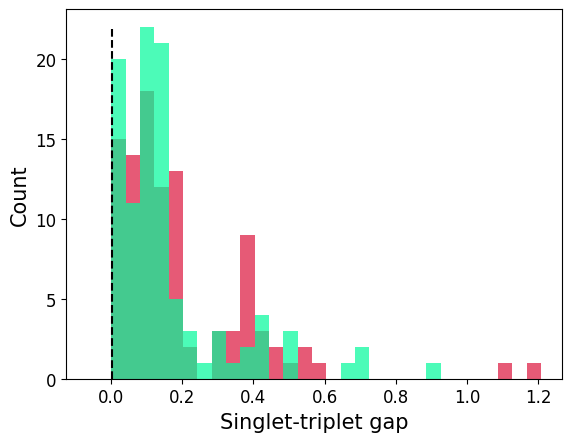

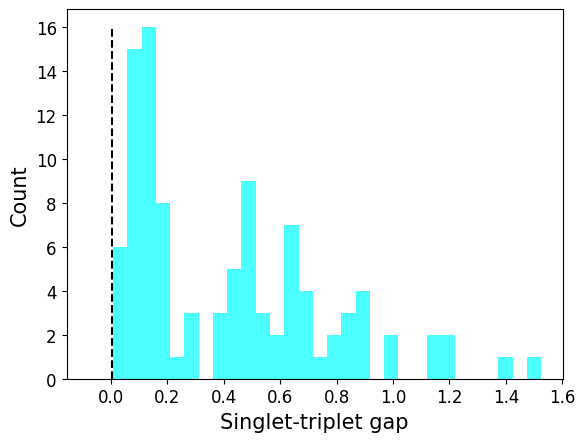

In [3]:
num_samples_in_each_fold = 10

data_set = "organic_emitter"
target = "singlet-triplet value"
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set+"_stv")
objective_index = 0
objective = "minimize"
cutoff = 0.002495
save_path = "figures/1.svg"

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
    
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path, expand_xlim=True)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_1.svg", expand_xlim=True)

## Organic emitter (oscillator strength)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 10.0%
janus_expected_improvement, top-10 hit rate: 10.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 6.0%
janus_expected_improvement, top-50 hit rate: 10.0%
janus_scaler, top-100 hit rate: 3.0%
janus_uncertainty, top-100 hit rate: 13.0%
janus_expected_improvement, top-100 hit rate: 7.000000000000001%


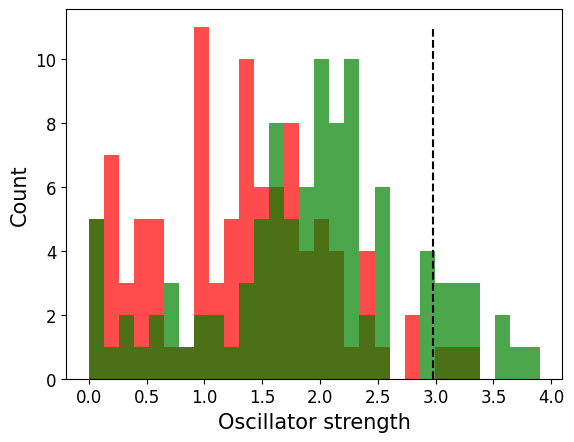

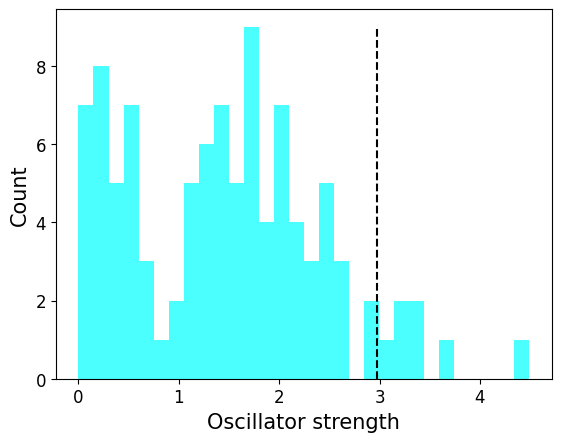

In [4]:
num_samples_in_each_fold = 10

data_set = "organic_emitter"
target = "oscillator strength"
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set+"_os")
objective_index = 1
objective = "maximize"
cutoff = 2.97372
save_path = "figures/2.svg"

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
    
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement":"cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement",]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_2.svg")

## Docking 1syh score (single objective)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 0.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 0.0%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_uncertainty, top-100 hit rate: 1.0%
janus_expected_improvement, top-100 hit rate: 0.0%


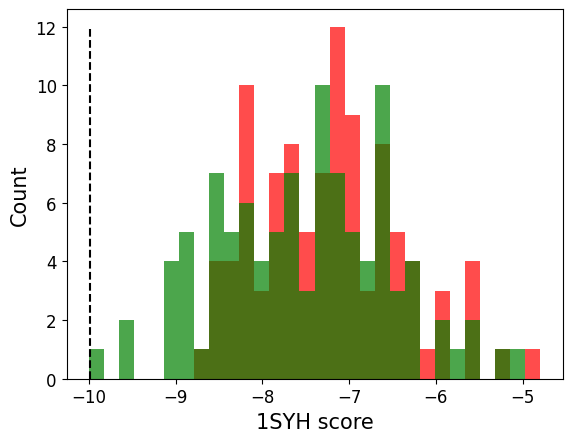

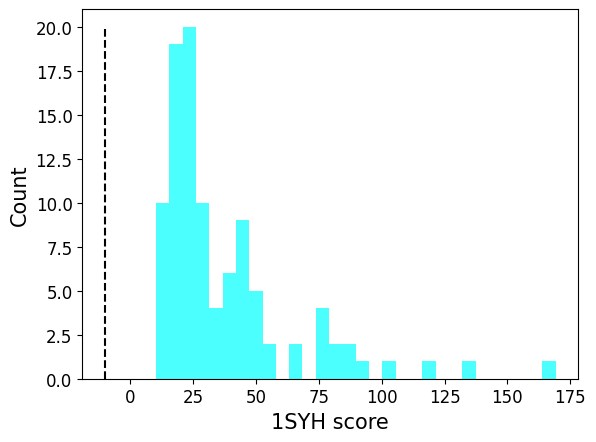

In [5]:
num_samples_in_each_fold = 10

data_set = "docking"
target = "1syh score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_1syh")
objective_index = 0
cutoff = -9.99
objective = "minimize"
save_path = "figures/3.svg"


cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]
color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement":"cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})


method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
overall_benchmark_dict.update({target: benchmark_dict})

create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_3.svg")

In [22]:
benchmark_dict["janus_uncertainty"][benchmark_dict["janus_uncertainty"]["1syh score"] < cutoff]

,1syh score,smiles,fitness
51,-11.9,CC1=c2c3cc4c(c2-3)C(CC=4)C1,1.0
215,-10.0,[N-]=[N+]=NC1=C(O)C2=CCCC3=C2C1=CC3,1.0
322,-10.1,[N-]=[N+]=NC1=C2CC3=C2C(=CC=CC3)C1,1.0


In [23]:
benchmark_dict["janus_scaler"][:100]

,1syh score,smiles,fitness
0,-4.8,c12c3c1c1c2c31,5.463763
1,-7.1,ON(S)N=c1c2c1c1c3c2c13,4.465595
2,-6.4,SNN=c1c2c1c1c3c2c13,4.347770
3,-6.9,C=CNC=c1c2c1c1c3c2c13,4.218170
4,-6.5,CNC=c1c2c1c1c3c2c13,4.174599
...,...,...,...
95,-5.6,C1Cc2c1c1c3c2c13,2.693928
96,-8.2,c1c2c1c1c3cc2c31,2.689598
97,-6.5,C1=Cc2c(c3c4c2c34)C1,2.628194
98,-7.9,CCC1=CCCC=C1c1c(C)c2c3c1c23,2.585067


## Docking 4lde score (single objective)

janus_scaler, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 100.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 48.0%
janus_uncertainty, top-50 hit rate: 96.0%
janus_expected_improvement, top-50 hit rate: 2.0%
janus_scaler, top-100 hit rate: 50.0%
janus_uncertainty, top-100 hit rate: 92.0%
janus_expected_improvement, top-100 hit rate: 3.0%


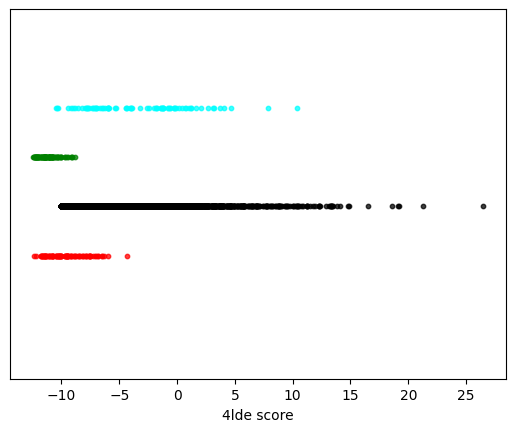

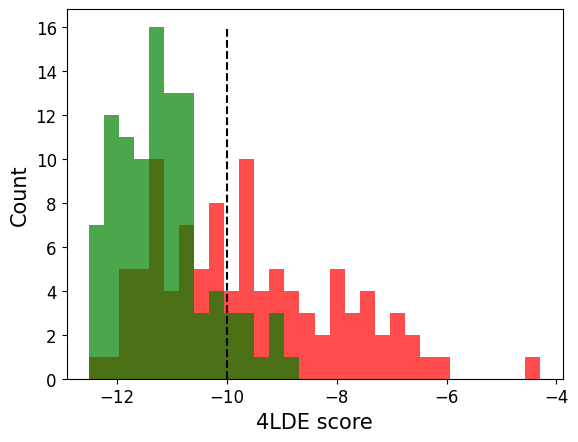

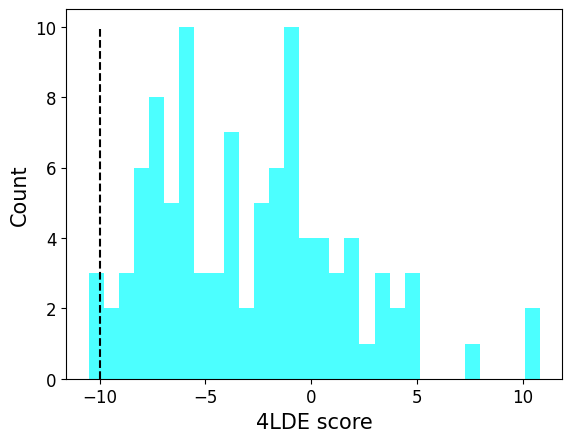

In [6]:
num_samples_in_each_fold = 5

data_set = "docking"
target = "4lde score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_4lde")
objective_index = 1
save_path = "figures/4.svg"

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

cutoff = -10.00
objective = "minimize"
color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green" ,"janus_expected_improvement":"cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_4.svg")

## Docking 6y2f score (single objective)

janus_scaler, top-10 hit rate: 50.0%
janus_uncertainty, top-10 hit rate: 80.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 62.0%
janus_uncertainty, top-50 hit rate: 56.00000000000001%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 52.0%
janus_uncertainty, top-100 hit rate: 49.0%
janus_expected_improvement, top-100 hit rate: 0.0%


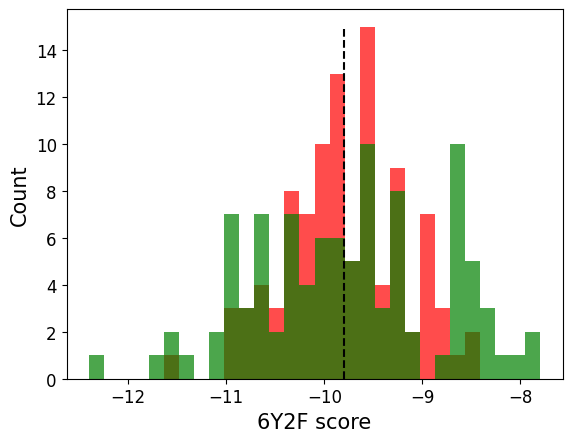

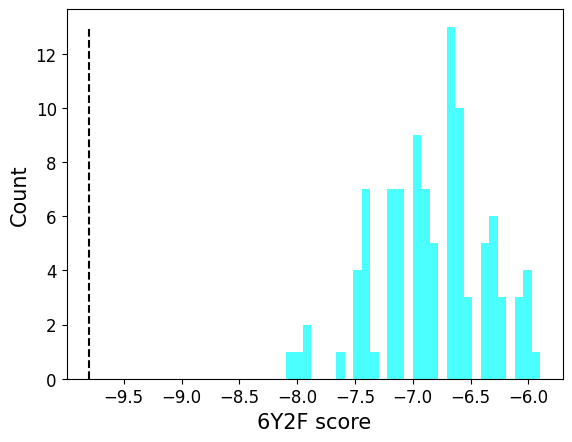

In [7]:
data_set = "docking"
target = "6y2f score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_6y2f")
objective_index = 2
cutoff = -9.80
objective = "minimize"
save_path = "figures/5.svg"


cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]
color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement": "cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})


method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_5.svg")

## Reactivity (activation energy)

janus_scaler, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 70.0%
janus_expected_improvement, top-10 hit rate: 30.0%
janus_scaler, top-50 hit rate: 26.0%
janus_uncertainty, top-50 hit rate: 42.0%
janus_expected_improvement, top-50 hit rate: 24.0%
janus_scaler, top-100 hit rate: 28.000000000000004%
janus_uncertainty, top-100 hit rate: 45.0%
janus_expected_improvement, top-100 hit rate: 17.0%


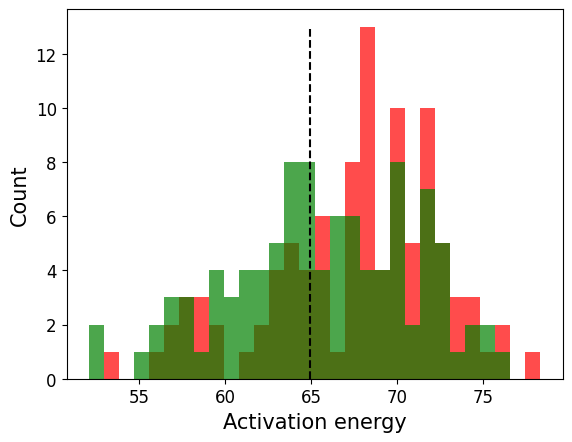

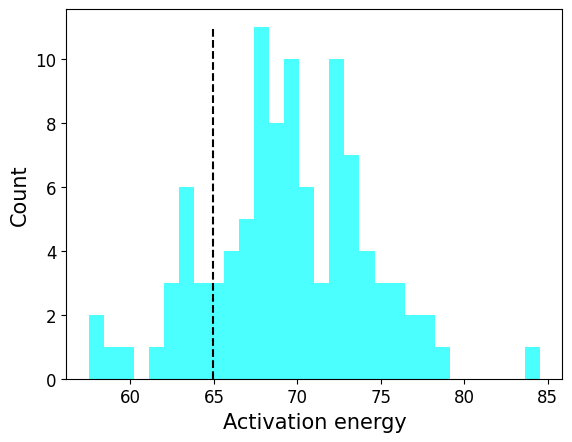

In [8]:
num_samples_in_each_fold = 10

data_set = "reactivity"
target = "activation_energy"
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set+"_activation_energy")
objective_index = 0
objective = "minimize"
cutoff = 64.9362
save_path = "figures/6.svg"

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement": "cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_6.svg")

In [41]:
benchmark_dict["janus_expected_improvement"]

,activation_energy,smiles,fitness
0,74.087291,BrC1C2CCC1C13C4C=CC(C4)C21N3CNCC=CCc1ccccc1,3.596022


## Reactivity (reaction energy)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 0.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 0.0%
janus_expected_improvement, top-50 hit rate: 4.0%
janus_scaler, top-100 hit rate: 0.0%
janus_uncertainty, top-100 hit rate: 0.0%
janus_expected_improvement, top-100 hit rate: 2.0%


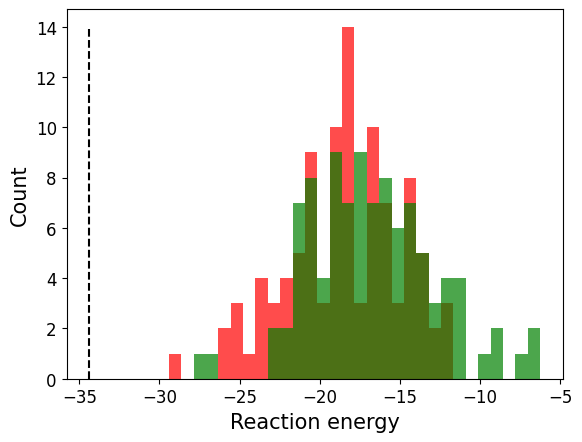

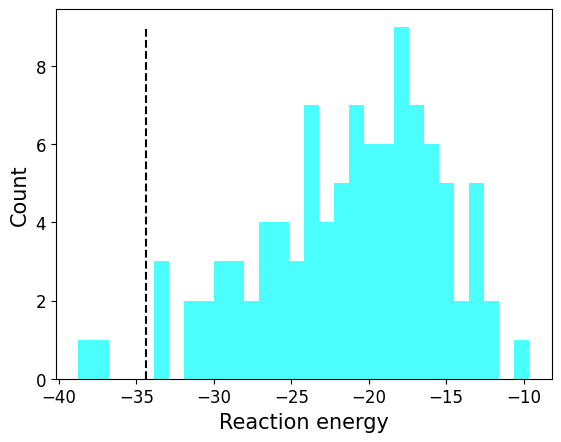

In [9]:
num_samples_in_each_fold = 20

data_set = "reactivity"
target = "reaction_energy"
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set+"_reaction_energy")
objective_index = 1
objective = "minimize"
cutoff = -34.3875
save_path = "figures/7.svg"

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement":"cyan"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff, save_path=save_path)
create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_7.svg")

In [14]:
df = benchmark_dict["janus_scaler"]
df.dropna()[:100].to_csv("re_scaler.csv",index=False)

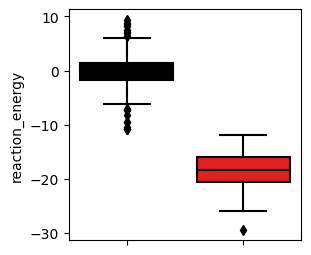

In [19]:
fig, ax = plt.subplots(figsize=(3,3))
create_box_plot(benchmark_dict, ["original data","janus_scaler"], color_dict,target,ax=ax,oneplot=False,ylabel=False)

In [10]:
from scipy.stats import iqr
def calc_IQR_times(data, objective):
    iqr_distance = iqr(data)
    if objective == "maximize":
        return (max(data) - data.quantile([0.75]).values[0]) / iqr_distance
    elif objective == "minimize":
        return (data.quantile([0.25]).values[0] - min(data)) / iqr_distance
    return None

all_targets = ['singlet-triplet value', "oscillator strength", '1syh score', '4lde score', '6y2f score',
              'activation_energy', 'reaction_energy']
all_objectives = ["minimize", "maximize", "minimize","minimize","minimize","minimize","minimize"]

for target, objective in zip(all_targets, all_objectives):
    iqr_times = calc_IQR_times(overall_benchmark_dict[target]['original data'][target], objective)
    print(target, "{:.3f}".format(iqr_times))

singlet-triplet value 1.249
oscillator strength 28.179
1syh score 0.660
4lde score 0.650
6y2f score 2.571
activation_energy 4.627
reaction_energy 7.640


## Plot 7 single-objective optimization results

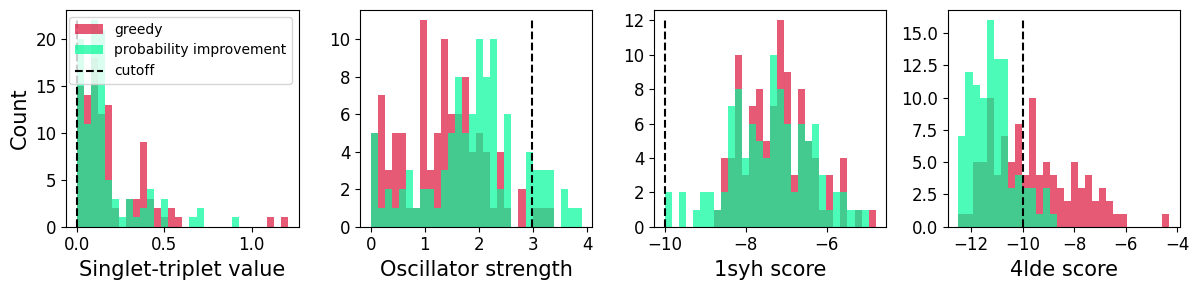

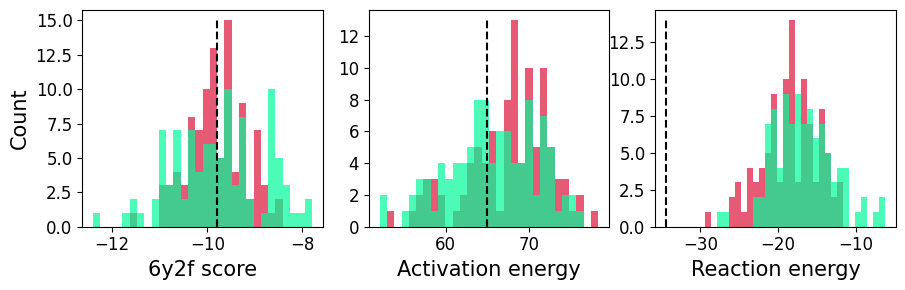

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.gridspec as gridspec

# color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement":"cyan"}
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"cyan"}
all_targets = ['singlet-triplet value', "oscillator strength", '1syh score', '4lde score', '6y2f score',
              'activation_energy', 'reaction_energy']
cutoff_dict = {'singlet-triplet value': 0.002495, "oscillator strength": 2.97372, 
               '1syh score': -9.99, '4lde score':-10.00, '6y2f score':-9.80,
               'activation_energy': 64.9362, 'reaction_energy': -34.3875}
objective_dict = {'singlet-triplet value': "minimize", "oscillator strength": "maximize", 
               '1syh score': "minimize", '4lde score':"minimize", '6y2f score':"minimize",
               'activation_energy': "minimize", 'reaction_energy': "minimize"}

fig = plt.figure(figsize=(12,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4):
    number = int("14"+str(i+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if i == 0:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False)
        plt.legend(labels=['greedy', 'probability improvement',"cutoff"])
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False,ylabel=False)
plt.tight_layout()
plt.savefig("figures/overall_1.svg")
plt.show()


fig = plt.figure(figsize=(9,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4,7):
    number = int("13"+str(i-4+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if i==4:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False)
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False,ylabel=False)

plt.tight_layout()
plt.savefig("figures/overall_2.svg")
plt.show()

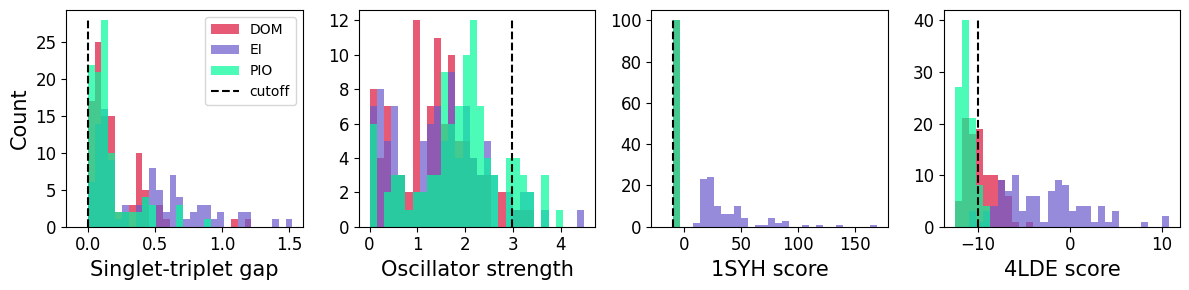

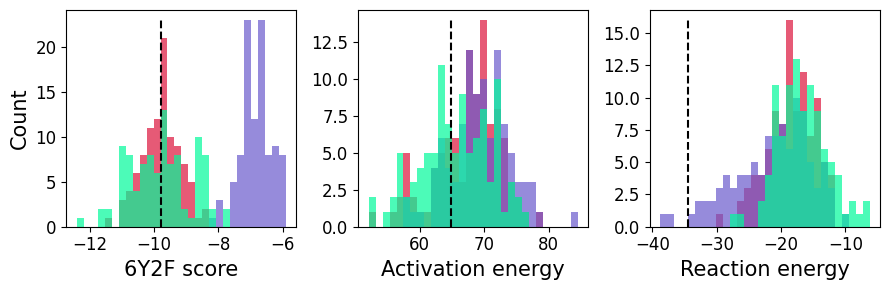

In [10]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.gridspec as gridspec

# color_dict = {"original data": "black", "janus_scaler":"#DC143C", "janus_uncertainty":"#228B22", "janus_expected_improvement":"cyan"}
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"} # 6A5ACD
all_targets = ['singlet-triplet value', "oscillator strength", '1syh score', '4lde score', '6y2f score',
              'activation_energy', 'reaction_energy']
cutoff_dict = {'singlet-triplet value': 0.002495, "oscillator strength": 2.97372, 
               '1syh score': -9.99, '4lde score':-10.00, '6y2f score':-9.80,
               'activation_energy': 64.9362, 'reaction_energy': -34.3875}
objective_dict = {'singlet-triplet value': "minimize", "oscillator strength": "maximize", 
               '1syh score': "minimize", '4lde score':"minimize", '6y2f score':"minimize",
               'activation_energy': "minimize", 'reaction_energy': "minimize"}

fig = plt.figure(figsize=(12,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4):
    number = int("14"+str(i+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if target in ['singlet-triplet value', '1syh score']:
        expand_xlim=True
    else:
        expand_xlim=False
    if i == 0:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False, expand_xlim=expand_xlim)
        plt.legend(labels=['DOM', 'EI','PIO', "cutoff"], fontsize=10)
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False,ylabel=False, expand_xlim=expand_xlim)
plt.tight_layout()
plt.savefig("figures/ei_overall_1.svg")
plt.show()


fig = plt.figure(figsize=(9,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4,7):
    number = int("13"+str(i-4+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if i==4:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False,)
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False,ylabel=False, )

plt.tight_layout()
plt.savefig("figures/ei_overall_2.svg")
plt.show()

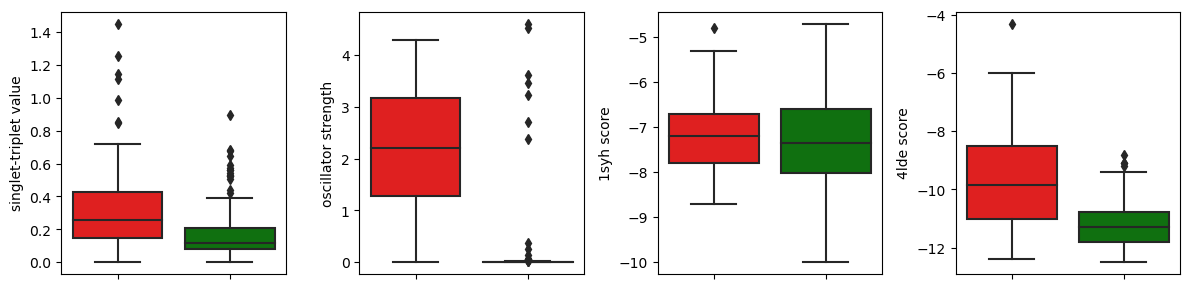

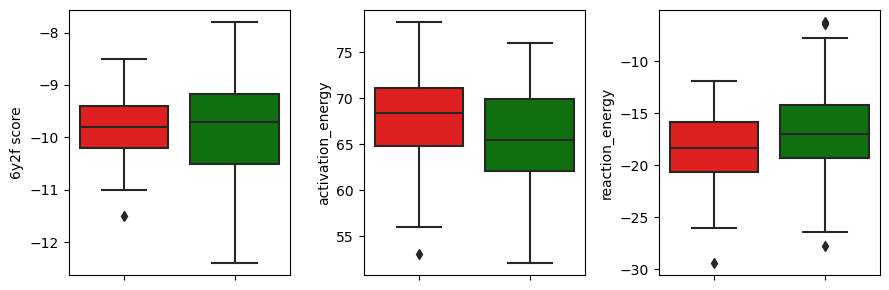

In [74]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.gridspec as gridspec


all_targets = ['singlet-triplet value', "oscillator strength", '1syh score', '4lde score', '6y2f score',
              'activation_energy', 'reaction_energy']

# fig = plt.figure()
fig, axes = plt.subplots(1,4, figsize=(12,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i, ax in zip([0,1,2,3], axes.flatten()):
    number = int("14"+str(i+1))
#     plt.subplot(number)
    target = all_targets[i]
    benchmark_dict = overall_benchmark_dict[target]
    if i == 0:
        create_box_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict,target,ax=ax, oneplot=False)
    else:
        create_box_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict,target,ax=ax,oneplot=False,ylabel=False)
plt.tight_layout()
plt.savefig("figures/overall_boxplot_1.svg")
plt.show()


# fig = plt.figure(figsize=(9,3))
fig, axes = plt.subplots(1,3, figsize=(9,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i, ax in zip([4,5,6], axes.flatten()):
    number = int("13"+str(i-4+1))
#     plt.subplot(number)
    target = all_targets[i]
    benchmark_dict = overall_benchmark_dict[target]
    if i==4:
        create_box_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target,ax=ax,oneplot=False)
    else:
        create_box_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty"], color_dict, target,ax=ax,oneplot=False,ylabel=False)

plt.tight_layout()
plt.savefig("figures/overall_boxplot_2.svg")
plt.show()

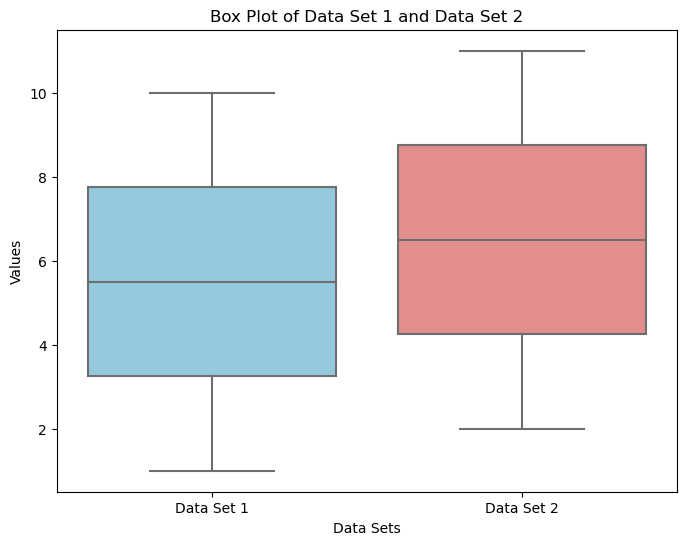

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 data1 和 data2 是你的兩個資料集
data1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data2 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# 創建一個資料框架，方便使用 seaborn 繪圖
import pandas as pd
df = pd.DataFrame({'Data Set': ['Data Set 1'] * len(data1) + ['Data Set 2'] * len(data2),
                   'Values': data1 + data2})

# 使用 seaborn 繪製 box plot，標籤和上色
plt.figure(figsize=(8, 6))
sns.boxplot(x='Data Set', y='Values', data=df, palette=['skyblue', 'lightcoral'])

# 設定圖表標題和軸標籤
plt.title('Box Plot of Data Set 1 and Data Set 2')
plt.xlabel('Data Sets')
plt.ylabel('Values')

# 顯示圖表
plt.show()

In [67]:
print(sub_dir_name)

['janus_scaler', 'original data', 'janus_uncertainty']


In [11]:
# 小結論: 貌似是single objective optimization在優化的方向上有聚集很多training data時，uncertainty的評估才比較有優勢。
# 如果今天優化的方向上缺乏training data給surrogate model的話，用uncertainty做single objective optimization相對於一般優化沒有優勢。